<font color='blue'> **Fazenda "dos Tacho" ______________________________________________________________________________** </font> 

In [1]:
%%capture
import flopy;import matplotlib.pyplot as plt;import numpy as np;from flopy.discretization import StructuredGrid;import os;from typing import List, Tuple, Union;from pathlib import Path
import pandas as pd;from flopy.utils.gridintersect import GridIntersect;from shapely.geometry import LineString, Polygon; import gisutils ; from flopy.plot import styles
import earthpy.spatial as es;import geopandas as gpd;import rioxarray as rxr;import rasterio as rio; from rasterio.plot import plotting_extent ;import earthpy.plot as ep ; from pandas import * 

TA = Path("./TA");TA.mkdir(exist_ok=True)  ;R1=Path('E:/15_REPOS/02_Beta-Me/data/Tacho_02')               ; R2  = (R1/'a00_Tacho_raster.tif')      ; TOPO=flopy.utils.Raster.load(R2) 
SHP1=os.path.join(R1/'06_bacia_vetor.shp') ;VEC1 = gpd.read_file(SHP1);OV1=VEC1.to_crs(es.crs_check(R2))  ; CRS = gisutils.get_shapefile_crs(SHP1) ; print('SHP:', CRS)     #es.crs_check(R2)

R4=Path('E:/15_REPOS/c01_EarthPy__Tacho/Tacho_03/n')      ;SHP2=os.path.join(R4/'simple04_300m_II_.shp')   ; VEC2 = gpd.read_file(SHP2) ; OV2 = VEC2.to_crs(es.crs_check(R2))

In [ ]:
XA=ExcelFile(os.path.join(R1/'poly.xlsx'))       ; DF0=XA.parse(XA.sheet_names[0])           ; DF0['ab'] = DF0['xcoord'].astype(str)+' '+DF0['ycoord'].astype(str) 
XA=ExcelFile(os.path.join(R1/'str1.xlsx'))       ; DF1=XA.parse(XA.sheet_names[0])           ; DF1['ab'] = DF1['xcoord'].astype(str)+' '+DF1['ycoord'].astype(str) 
XA=ExcelFile(os.path.join(R1/'str2.xlsx'))       ; DF2=XA.parse(XA.sheet_names[0])           ; DF2['ab'] = DF2['xcoord'].astype(str)+' '+DF2['ycoord'].astype(str) 
XA=ExcelFile(os.path.join(R1/'str3.xlsx'))       ; DF3=XA.parse(XA.sheet_names[0])           ; DF3['ab'] = DF3['xcoord'].astype(str)+' '+DF3['ycoord'].astype(str) 

LIST1 = list(zip(DF0['xcoord'],DF0['ycoord']))   ; CCA=np.array(LIST1)                             ; #CCA #CCB 
L1    = list(zip(DF1['xcoord'],DF1['ycoord']))   ; L2=list(zip(DF2['xcoord'],DF2['ycoord']))       ; L3=list(zip(DF3['xcoord'],DF3['ycoord']))              ; LIST2=[L1,L2,L3]   ; DF0.head(2)
pd.DataFrame(LIST2[0]).to_csv(TA/'SRT00.csv')    ; pd.DataFrame(LIST2[1]).to_csv(TA/'SRT01.csv')   ; pd.DataFrame(LIST2[len(LIST2)-1]).to_csv(TA/'SRT02.csv')            # print(len(LIST2)-1)

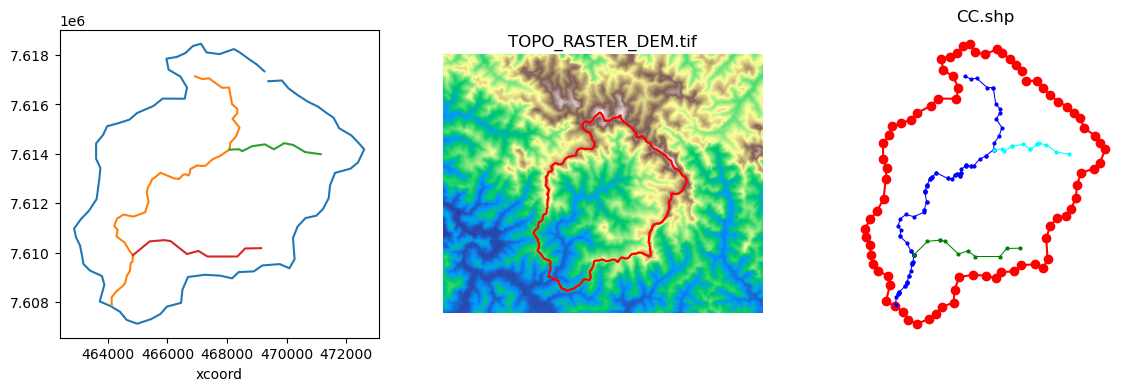

In [ ]:
fig = plt.figure(figsize=(14,4))                                                         
ay = fig.add_subplot(131)  ; DF0.plot(x='xcoord',y='ycoord', ax=ay)  ;DF1.plot(ax=ay,x='xcoord',y='ycoord')  ;DF2.plot(ax=ay,x='xcoord',y='ycoord')   ;DF3.plot(ax=ay,x='xcoord',y='ycoord')
ax = fig.add_subplot(132)  ; TOPO.plot(ax=ax, cmap="terrain")        ;OV1.boundary.plot(ax=ax, color='red')  ;plt.title("TOPO_RASTER_DEM.tif")        ;plt.axis('off') 
ax = fig.add_subplot(133)  ; ax.set_aspect("equal")                  ;COL=("blue","cyan","green","orange")   ;ax.plot(CCA[:,0],CCA[:,1], "ro-")                               
for idx, SG in enumerate(LIST2) : CCB = np.array(SG)                 ;plt.title("CC.shp") ;plt.axis('off')   ;ax.plot(CCB[:,0],CCB[:,1], color=COL[idx],lw=0.75, marker="o", markersize=2)
ay.legend().set_visible(False)  ; plt.show(block=False)     

<font color='orange'> **GRID ______________________________________________________________________________** </font> 

In [4]:
XMIN=DF0['xcoord'].min();YMIN=DF0['ycoord'].min()   ;XMAX=DF0['xcoord'].max();YMAX=DF0['ycoord'].max()           #; print('Lx=', XMAX-XMIN)   ; print('Ly=',YMAX-YMIN)
Lx=(XMAX-XMIN)*1.1 ;Ly=(YMAX-YMIN)*1.1              ;dx=dy=125       ;nrow=int(Ly/dy)+1   ;ncol=int(Lx/dx)+1   ; XOFF = XMIN-Lx*0.05       ; YOFF = YMIN-Ly*0.05    # 250.0

BOT=np.full((1,nrow,ncol),900.0); TOP=np.full((nrow, ncol),1200.0)
def STRUCT(modelgrid: flopy.discretization.StructuredGrid  ,boundary: List[tuple]) -> None:
    global idomain
    IX = GridIntersect(modelgrid,method="vertex",rtree=True)   ; RES=IX.intersect(Polygon(boundary))  ;idx=[coords for coords in RES.cellids] ;idx=np.array(idx,dtype=int) ; NR=idx.shape[0]
    if idx.ndim == 1:  idx = idx.reshape((NR, 1))
    idx = tuple([idx[:, i] for i in range(idx.shape[1])])      ; idomain=np.zeros(modelgrid.shape[1:], dtype=int)    ; idomain[idx]=1 ;idomain=idomain.reshape(modelgrid.shape)
    modelgrid.idomain = idomain         ; return

GRID=StructuredGrid(nlay=1 ,delr=np.full(ncol, dx),delc=np.full(nrow,dy)    ,xoff=XOFF,yoff=YOFF  ,top=TOP,botm=BOT,crs=32723)      ;STRUCT(GRID,LIST1) ; GRID#;LIST1

TT=TOPO.resample_to_grid(GRID,band=TOPO.bands[0],method="linear",extrapolate_edges=True)  

In [5]:
pd.DataFrame(idomain[0,:,:]).to_csv(TA/'2D_grid.csv')                                              
def intersect_segments(modelgrid:   Union[flopy.discretization.StructuredGrid,flopy.discretization.VertexGrid],segments:List[List[tuple]]) -> Tuple[flopy.utils.GridIntersect,list,list]:
    ixs = flopy.utils.GridIntersect(modelgrid,method=modelgrid.grid_type)  ; cellids = []         ; lengths = []
    for sg in segments:                    v = ixs.intersect(LineString(sg), sort_by_cellid=True) ; cellids += v["cellids"].tolist()  ; lengths += v["lengths"].tolist()
    return ixs, cellids, lengths
ixs, cellids, lengths = intersect_segments(GRID, LIST2)                                           ; INTER = np.zeros(GRID.shape[1:])       ; 
for loc in cellids:     INTER[loc] = 1
RIV = GRID.idomain[0].copy() ; index = tuple(np.array(list(zip(*cellids))))                       ; RIV [index]=2  ;GRID.idomain=RIV.reshape(1, nrow, ncol)

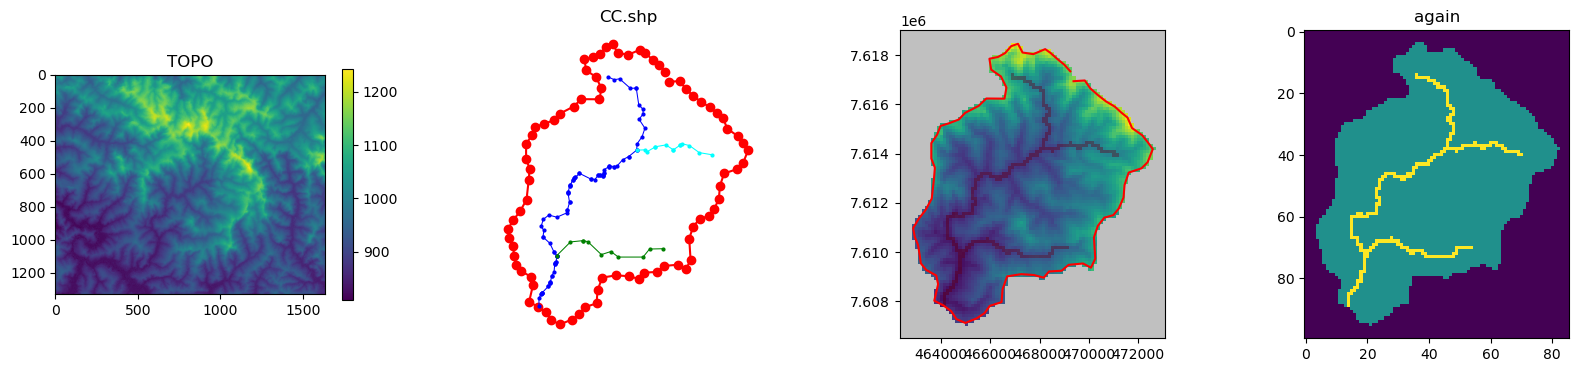

In [ ]:
with rio.open(R2) as src: BAND = src.read(1)     ; extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]   #; extent

fig = plt.figure(figsize=(20,4))                                                         
ax = fig.add_subplot(141)       ; f = np.array(BAND) ; plt.imshow(f, interpolation="nearest", origin="upper")           ; plt.colorbar(shrink=0.75) ; plt.title("TOPO")
ax = fig.add_subplot(142)       ; ax.set_aspect("equal")   ; COL=("blue","cyan","green","orange")     ; ax.plot(CCA[:,0],CCA[:,1], "ro-")                               
for idx, SG in enumerate(LIST2) : CCB = np.array(SG)       ; plt.title("CC.shp") ;plt.axis('off')     ; ax.plot(CCB[:,0],CCB[:,1], color=COL[idx],lw=0.75, marker="o", markersize=2)

ax = fig.add_subplot(143)       ; PM=flopy.plot.PlotMapView(modelgrid=GRID) ; ax.set_aspect("equal");PM.plot_array(TT) ; PM.plot_array(INTER,masked_values=[0,],alpha=0.2,cmap="Reds_r")

PM.plot_inactive(color_noflow="silver")                                     ; ax.plot(CCA[:, 0], CCA[:, 1], "red")   
ax = fig.add_subplot(144)       ; plt.imshow(GRID.idomain[0])                                                          ; plt.title("again") ; plt.show(block=False)    # ; plt.axis('off') 

<font color='Orange'> **DRN ______________________________________________________________________________** </font> 

In [7]:
def Drain_data(modelgrid:           Union[flopy.discretization.StructuredGrid,flopy.discretization.VertexGrid],cellids:list,lengths:list,leakance:float,elevation:np.ndarray,) -> List[tuple]:
    global DRN; DRN = []
    for cellid, length in zip(cellids, lengths):
        x = modelgrid.xcellcenters[cellid]    ; width = 5.0+(14.0/Lx)*(Lx-x)  ; COND = abs(leakance*length*width)/5
        if not isinstance(cellid, tuple):      cellid = (cellid,)
        DRN.append((0, *cellid, elevation[cellid], COND))
    return DRN
dv0 = 2.5  ; leakance = 1.0 / (0.5 * dv0)     ; DRN = Drain_data(GRID,cellids,lengths,leakance,TT)  ; Drn = pd.DataFrame(DRN) ;Drn.to_csv(TA/'DRN.csv') ; Drn.tail(2)

,0,1,2,3,4
229,0,71,20,854.3048,1548.266670
230,0,72,20,841.6168,14363.807324


<font color='Orange'> **DISC ______________________________________________________________________________** </font> 

In [8]:
LEA = 0.5
def Cell_areas(modelgrid:           Union[flopy.discretization.StructuredGrid, flopy.discretization.VertexGrid]) -> np.ndarray:
    if modelgrid.grid_type == "structured": 
        nrow, ncol = modelgrid.nrow, modelgrid.ncol    ; areas = np.zeros((nrow, ncol), dtype=float)
        for r in range(nrow):
            for c in range(ncol):                       cellid = (r, c) ; vertices = np.array(modelgrid.get_cell_vertices(cellid)) ; area = Polygon(vertices).area ; areas[cellid] = area
    elif modelgrid.grid_type == "vertex":   
        areas = np.zeros(modelgrid.ncpl, dtype=float)
        for idx in range(modelgrid.ncpl):               vertices = np.array(modelgrid.get_cell_vertices(idx))  ; area = Polygon(vertices).area      ; areas[idx] = area
    else:   raise ValueError(+ f"{modelgrid.grid_type}")
    return areas

def GW_discharge_data(modelgrid:    Union[flopy.discretization.StructuredGrid, flopy.discretization.VertexGrid]  ,leakance: float  ,elevation: np.ndarray,) -> List[tuple]:
    areas = Cell_areas(modelgrid)   ; DRN = [] ; idomain = modelgrid.idomain[0]
    for idx in range(modelgrid.ncpl):
        if modelgrid.grid_type == "structured":  r, c = modelgrid.get_lrc(idx)[0][1:]  ; cellid = (r, c)
        else:                                    cellid = idx  
        area = areas[cellid]
        if idomain[cellid] == 1:    
            COND = leakance * area  * LEA  
            if not isinstance(cellid, tuple):    cellid = (cellid,)
            DRN.append((0, *cellid, elevation[cellid] - 0.5, COND, 1.0))
    return DRN
DIS = GW_discharge_data(GRID,leakance,TT)  ; Dis = pd.DataFrame(DIS) ;Dis.to_csv(TA/'DIS.csv') ; Dis.tail(2)

,0,1,2,3,4,5
4007,0,94,23,907.7336,6250.0,1.0
4008,0,95,21,899.5712,6250.0,1.0


In [9]:
nlay=5 ;idomain=np.array([GRID.idomain[0,:,:].copy() for k in range(nlay)])  ; IC=np.array([TT.copy() for k in range(nlay)] ,dtype=float)     ;TOPC = np.zeros((nlay,nrow,ncol),dtype=float)
BOTM = np.zeros((nlay,nrow,ncol), dtype=float)                               ; dv=dv0 ; TOPC[0] = TT.copy()                        ; BOTM[0] = TOPC[0]-dv    ; print('dv0_DRN_______:', dv0)
for idx in range(1, nlay):  dv *= 2.25       ; TOPC[idx]=BOTM[idx-1]         ; BOTM[idx] = TOPC[idx] - dv                   
for k in range(nlay): print((TOPC[k]-BOTM[k]).mean())

dv0_DRN_______: 2.5
2.5
5.625
12.65625
28.4765625
64.072265625


In [10]:
K11=0.001; REC = 0.000001      # 0.000001
sim = flopy.mf6.MFSimulation(sim_ws=TA,exe_name="mf6",memory_print_option="summary",)                                                     ; flopy.mf6.ModflowTdis   (sim)
flopy.mf6.ModflowIms        (sim,complexity="simple",print_option="SUMMARY",csv_outer_output_filerecord="outer.csv",csv_inner_output_filerecord="inner.csv",linear_acceleration="bicgstab"
                                ,outer_maximum=1000,inner_maximum=100,outer_dvclose=1e-4,inner_dvclose=1e-5,preconditioner_levels=2,relaxation_factor=0.0)
gwf = flopy.mf6.ModflowGwf  (sim,print_input=True,save_flows=True,newtonoptions="NEWTON UNDER_RELAXATION")
flopy.mf6.ModflowGwfdis  (gwf   ,nlay=nlay,nrow=nrow,ncol=ncol,delr=dx,delc=dy,idomain=idomain,top=TT,botm=BOTM,xorigin=0.0,yorigin=0.0)   ; flopy.mf6.ModflowGwfic   (gwf, strt=IC)
flopy.mf6.ModflowGwfnpf  (gwf   ,save_specific_discharge=True,icelltype=1,k=K11)                                                           ; flopy.mf6.ModflowGwfrcha (gwf, recharge=REC)
flopy.mf6.ModflowGwfdrn  (gwf                                                    ,maxbound=len(DRN) ,stress_period_data=DRN ,pname="DRN1"  ,filename="drn_riv.drn")    # _______ DRN _______ 
flopy.mf6.ModflowGwfdrn  (gwf   ,auxiliary=["depth"] ,auxdepthname="depth"       ,maxbound=len(DIS) ,stress_period_data=DIS ,pname="DRN2"  ,filename="drn_gwd.drn")    # __EVERWHERELSE__0 Layer
flopy.mf6.ModflowGwfoc   (gwf   ,head_filerecord=f"{gwf.name}.hds",budget_filerecord=f"{gwf.name}.cbc",saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],printrecord=[("BUDGET", "ALL")]) ; 

sim.write_simulation(silent=True)                                               ; success, buff = sim.run_simulation(silent=True)                                ; assert success

<font color='Orange'> **RES ______________________________________________________________________________** </font> 

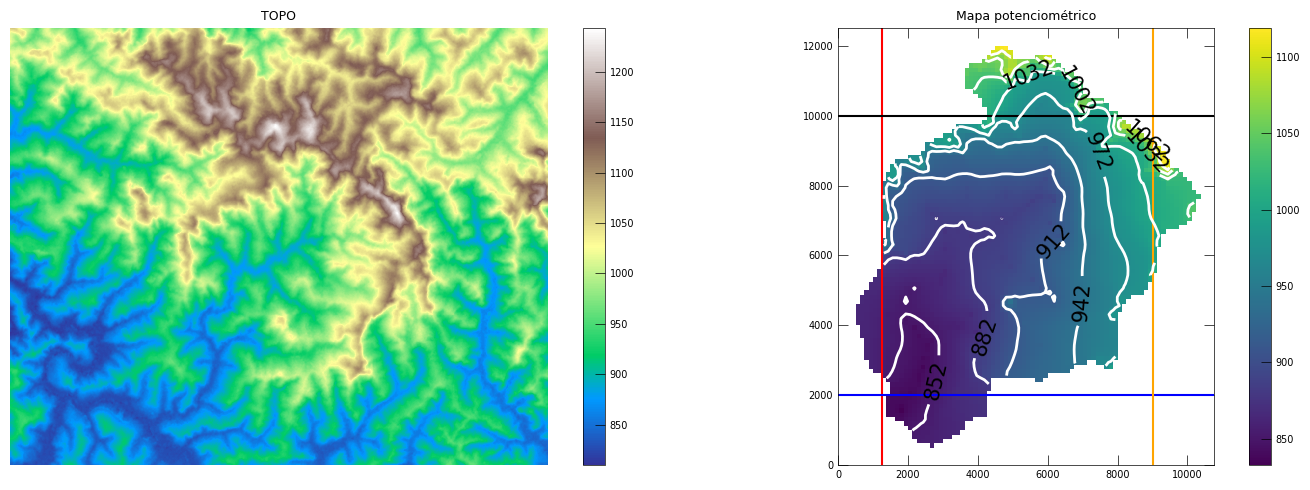

DIS_max: 12 x 10 KM _____ COL_max: 100 86
A: 10 8 ______  1250 1000
B: 90 77 _____ 11250 9625


In [16]:
CO=30   ;WT=flopy.utils.postprocessing.get_water_table(gwf.output.head().get_data())  ;H0=gwf.output.head().get_data()  ;hmin,hmax=WT.min(),WT.max();CONT=np.arange(hmin*.05,hmax, CO)
with styles.USGSMap():                     
    fig = plt.figure(figsize=(14, 5))
    ax = fig.add_subplot(121)  ; f = np.array(BAND) ;plt.imshow(f,interpolation="nearest",origin="upper",cmap="terrain") ; plt.colorbar(shrink=1) ;plt.title("TOPO") ;plt.axis('off') 
    ax = fig.add_subplot(122)  ; ax.set_aspect("equal")  
    ax.plot([1250 , 1250],[-100,15000],color='r') ;ax.plot([-100,12000],[ 2000, 2000],color='b');ax.plot([9000,9000],[-100,15000],color='orange');ax.plot([-100,12000],[10000,10000],color='black')
    pmv = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, ax=ax)                          ; HH = pmv.plot_array(H0, vmin=hmin, vmax=hmax, alpha=1)    ; plt.colorbar(HH, ax=ax, shrink=1)
    CC = pmv.contour_array(WT,levels=CONT,colors="white" ,linewidths=2,linestyles="-",)   ; plt.clabel(CC, fontsize=15,colors="black" )               ; plt.title("Mapa potenciométrico")
#    ax.plot(CCA[:,0], CCA[:,1], "red",linewidth=4)      ; plt.title("HEADS")             \ for SG in LIST2:  CCB = np.array(SG)                ; ax.plot(CCB[:,0], CCB[:,1], "b")                  
plt.tight_layout()             ; plt.show(block=False)                                    #; print('Hmin:',int(hmin), 'Hmax:',int(hmax), 'DIF:', -int(hmin)+int(hmax))  

aa=int(nrow)*0.1;bb=int(ncol)*0.1;cc=int(nrow)*0.9;dd=int(ncol)*0.9  ; print('DIS_max:',int(nrow*dx/1000),'x',int(ncol*dy/1000),'KM','_____ COL_max:',nrow,ncol)    
print('A:',int(aa),int(bb),'______ ',int(aa)*dy,int(bb)*dx)          ; print('B:',int(cc),int(dd),'_____',int(cc)*dy,int(dd)*dx)

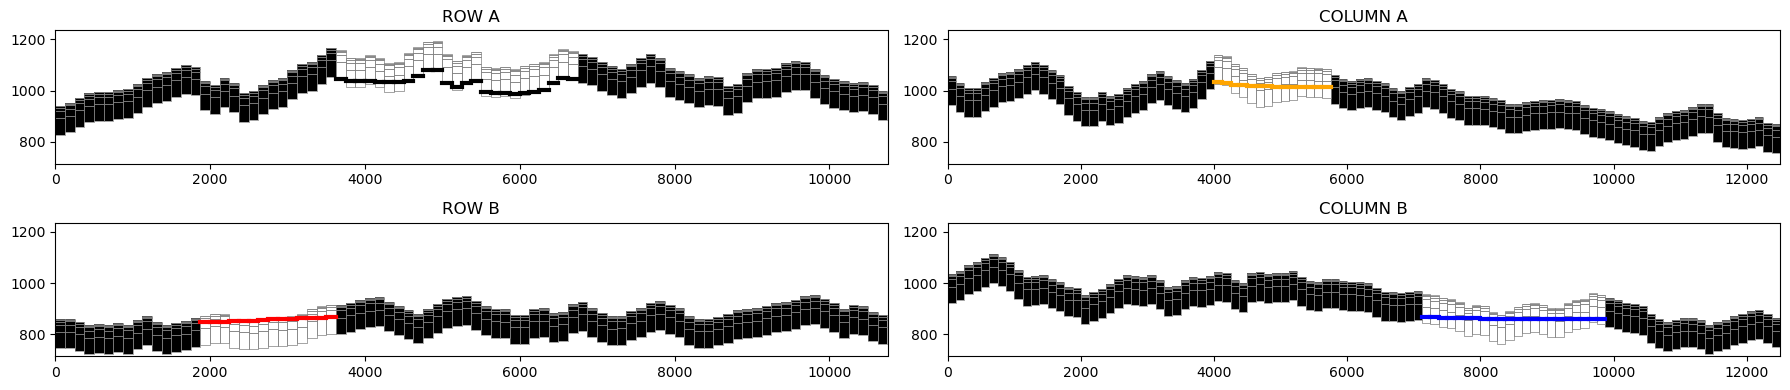

In [23]:
fig = plt.figure(figsize=(18, 4))
ax=fig.add_subplot(221);W=flopy.plot.PlotCrossSection(model=gwf,ax=ax,line={"row":   aa});W.plot_inactive();plt.title("ROW A")   ;W.plot_grid(linewidth=0.5) ;W.plot_surface(WT,color="black" ,lw=3)  
ax=fig.add_subplot(222);W=flopy.plot.PlotCrossSection(model=gwf,ax=ax,line={"column":dd});W.plot_inactive();plt.title("COLUMN A");W.plot_grid(linewidth=0.5) ;W.plot_surface(WT,color="orange",lw=3)
ax=fig.add_subplot(223);W=flopy.plot.PlotCrossSection(model=gwf,ax=ax,line={"row":   cc});W.plot_inactive();plt.title("ROW B")   ;W.plot_grid(linewidth=0.5) ;W.plot_surface(WT,color="r"     ,lw=3)  
ax=fig.add_subplot(224);W=flopy.plot.PlotCrossSection(model=gwf,ax=ax,line={"column":bb});W.plot_inactive();plt.title("COLUMN B");W.plot_grid(linewidth=0.5) ;W.plot_surface(WT,color="blue"  ,lw=3)  
plt.tight_layout() ; plt.show(block=False) 

Beta-me!